In [1]:
# If using colab 
# !pip install "pyGTFSHandler[osm,plot] @ git+https://github.com/CityScope/pyGTFSHandler.git"
# !pip install matplotlib mapclassify folium

In [2]:
import sys 
sys.path.append('/home/miguel/Documents/Proyectos/PTLevelofService/gtfs/pyGTFSHandler')

In [3]:
import os

from pyGTFSHandler.feed import Feed
from pyGTFSHandler.downloaders.mobility_database import MobilityDatabaseClient
from pyGTFSHandler.utils import get_geographic_suggestions_from_string
from pyGTFSHandler.utils import get_city_geometry
import pyGTFSHandler.plot_helpers as plot_helpers
import pyGTFSHandler.gtfs_checker as gtfs_checker
import pyGTFSHandler.processing_helpers as processing_helpers
from datetime import datetime, date, timedelta, time
import pandas as pd
import polars as pl 
import geopandas as gpd
import numpy as np
from shapely import wkt

import matplotlib.pyplot as plt

In [4]:
def df_to_stop_gdf(df):
    if isinstance(df,pl.LazyFrame):
        df = df.collect()
    if isinstance(df, pl.DataFrame):
        df = df.to_pandas()

    df = gpd.GeoDataFrame(df,geometry=gpd.points_from_xy(df['stop_lon'],df['stop_lat']),crs=4326)
    return df 

In [5]:
city_name = "Cambridge, Massachusetts, USA"
download_buffer = 2000 # In meters
start_date=date.today() # If None take the feed min date
end_date=date.today() + timedelta(days=30) # If None take the feed max date
start_time = time(hour=8)
end_time = time(hour=20)

route_types = 'all' # Valid values are 'tram' 'subway' 'rail' 'bus' 'ferry' 'cable_car' 'gondola' 'funicular' 
# or any list combining those like ['rail', 'subway']
stop_id = "parent_station" # Use the stop groups created with arg stop_group_distance in Feed to group neraby stops into one
# You could choose 'stop_id' too
stop_group_distance=100 # In meters. Group nearby stops into the same 'parent_station' 

In [6]:
# Name of the folder with results
city_filename = gtfs_checker.normalize_string(city_name)
# Area of interest as a Polygon
aoi = get_city_geometry(city_name)
# Area used for downloading data
aoi_download = aoi.to_crs(aoi.estimate_utm_crs()).buffer(download_buffer)
# Country, State and Municipality of your AOI
geo_suggestions = get_geographic_suggestions_from_string(city_name)
geo_suggestions

{'country_codes': ['US'],
 'subdivision_names': ['Massachusetts', 'Middlesex County'],
 'municipalities': ['Cambridge', 'Middlesex County']}

In [7]:
# Save all files in a dir with the name of the city
os.makedirs(city_filename,exist_ok=True)

In [8]:
# Request your refresh token here: https://mobilitydatabase.org/ 
refresh_token = 'AMf-vByYiwMAni1pw6yTpwgwwYFc8HR4y0zUKZGPT4sjJ0wUrIXOfVxF1KotRIvEgAseaaNheL8YczJiCILb6o2PUh-8zjA-qQURzEc8tELlwFiDopMoqJnkDf13AqNaGGnnzTDmYM20AWEquUxcYFAB8Q3e5rI2DcTBSQuiUdHL8bi48xmUJk3tayHpnoicoppi_evDcWYODwOJFcwnta3K7f718w7R2JRM0zDEOYw7nI7thrQa9462BENdpv8zv8mEbBssEa189k6YcV__sQAZlng2EcsCGA'
api = MobilityDatabaseClient(refresh_token)

2026-02-01 00:39:33,578 - INFO - Obtaining or refreshing access token...
2026-02-01 00:39:33,847 - INFO - Access token obtained successfully.


#### Search feeds

In [9]:
feeds = api.search_gtfs_feeds(
    country_code=geo_suggestions['country_codes'],
    # This info is not always in the feeds metadata. Comment this if you did not find all feeds.
    subdivision_name=geo_suggestions['subdivision_names'],
    # This info is not always in the feeds metadata. Comment this if you did not find all feeds.
    municipality=geo_suggestions['municipalities'],
    # Set to True if you only want official feeds otherwise set to None (False means only unofficial)
    # is_official=True, 
    # You could comment the rest of search args and use only aoi
    # Sometimes the API seems to not do this very well as the metadata is often wrong.
    # aoi=aoi_download, 
)

for f in feeds:
    print(f['provider'])

128 Business Council
Massachusetts Bay Transportation Authority (MBTA)
Middlesex 3 TMA
Amtrak
Harvard University
Merrimack Valley Regional Transit Authority (MVRTA)
Montachusett Regional Transit Authority (MART)
Peter Pan


#### Download feeds

In [10]:
orig_file_paths = api.download_feeds(
    feeds=feeds,
    download_folder=city_filename+"/orig_gtfs_files",
    overwrite=False
)

2026-02-01 00:39:35,379 - INFO - Successfully downloaded 8 feeds.


In [11]:
# A) Do not fix the gtfs. Feed has a fast basic gtfs fixer but does not log all the errors.

file_paths = orig_file_paths

# B) Check and fix the gtfs files (This takes a few minutes). Set check_files = False in Feed to load faster

# file_paths = []
# for f in orig_file_paths:
#     filename = os.path.splitext(os.path.basename(f))[0]
#     if os.path.isdir(os.path.join(city_filename,"gtfs_files",filename)):
#         file_paths.append(os.path.join(city_filename,"gtfs_files",filename))
#     else:
#         file_paths.append(gtfs_checker.preprocess_gtfs(f,city_filename+"/gtfs_files"))

### Feed object

This object contains all methods you can do with the GTFS and a dataframe with all info

Any method of the Feed object return a polars dataframe. If you want the dataframe as pandas to .to_pandas()

In [12]:
gtfs = Feed(
    file_paths,
    aoi=aoi,
    # Group stops into same that are less than x meters apart. This updates the parent_station column
    stop_group_distance=stop_group_distance, 
    start_date=start_date, # If None take the feed min date
    end_date=end_date, # If None take the feed max date
    route_types=route_types
)

### Service Intensity

This is the number of vehicles that arrive at each stop every day multiplied by the number of stops:

$\text{Service Intensity} = (\text{Number of vehicles per stop}) \times (\text{Number of stops})$

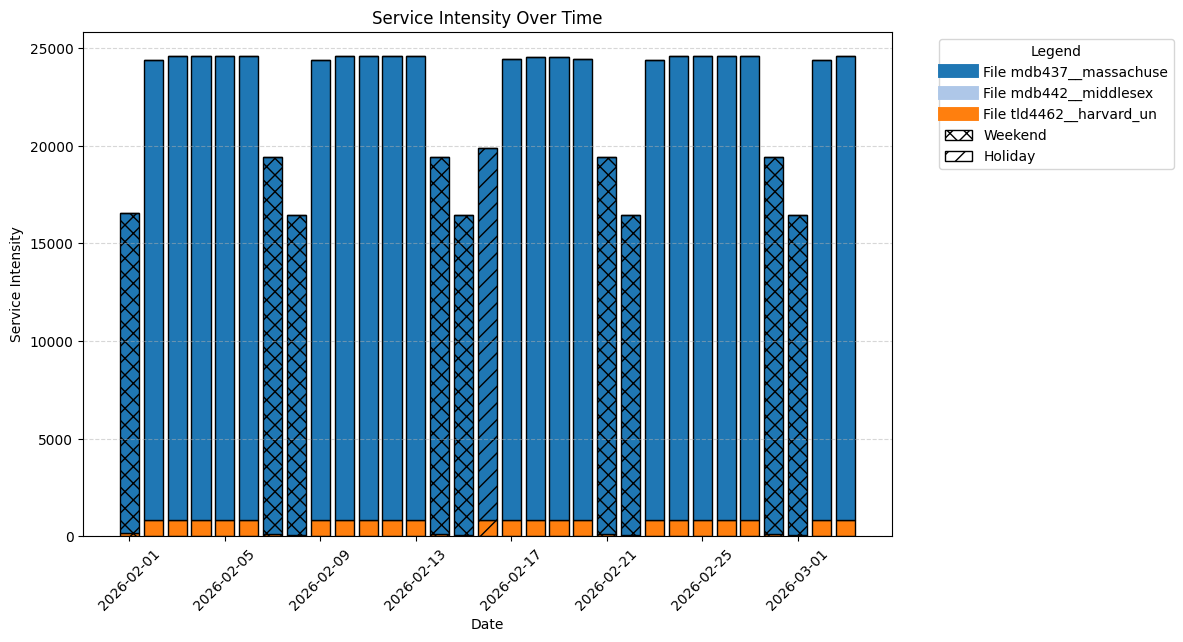

In [13]:
service_intensity = gtfs.get_service_intensity_in_date_range(
    start_date=None, # If None take the feed min date
    end_date=None, # If None take the feed max date
    date_type=None, # Could be something like 'holiday', 'weekday', or 'monday' to only consider some dates from the range.
    by_feed=True
)
service_intensity = service_intensity.to_pandas()
plot_helpers.service_intensity(service_intensity)

Select the most representative business day in a date range

In [14]:
idx = processing_helpers.most_frequent_row_index(service_intensity)
selected_day = service_intensity.iloc[idx]['date'].to_pydatetime()
selected_day

datetime.datetime(2026, 2, 3, 0, 0)

## Speed

#### Stop speed 

At every stop and by every route 

Speeds are in *km/h*

In [15]:
stop_speed_df = gtfs.get_speed_at_stops(
    date=selected_day,
    start_time=start_time,
    end_time=end_time,
    route_types = route_types,
    by = "route_id", # Speed is computed for every 'trip_id' and grouped by this column with the how method
    at = stop_id, # Compute speed for every 'parent_station' 'stop_id' or 'route_id'
    how="mean", # How to group individual trip speeds 'mean' 'max' or 'min'
    direction="both", # Compute speed in 'forward' 'backward' or 'both' directions (walking n_stops in direction)
    time_step=15, # Number of minutes to move to compute speed
).to_pandas()
stop_speed_df = gtfs.add_stop_coords(stop_speed_df)
stop_speed_df = gtfs.add_route_names(stop_speed_df)
stop_speed_df = df_to_stop_gdf(stop_speed_df)
stop_speed_df = stop_speed_df.sort_values(stop_id).reset_index(drop=True)
stop_speed_df = stop_speed_df[stop_speed_df.geometry.is_valid]
stop_speed_df 

/home/miguel/Documents/Proyectos/PTLevelofService/gtfs/pyGTFSHandler/pyGTFSHandler/feed.py:1949: UserWarning: Sortedness of columns cannot be checked when 'by' groups provided
  return gtfs_lf.filter(pl.col("isin_aoi") == True).drop("isin_aoi").collect()
sys:1: UserWarning: Sortedness of columns cannot be checked when 'by' groups provided


,parent_station,route_id,distance_weight,time_weight,n_trips,speed,stop_lat,stop_lon,stop_name,route_short_name,route_long_name,route_name,route_type,route_type_text,geometry
0,101_file_1,70_file_1,1573.226278,600.000000,50,9.439358,42.362896,-71.099497,Massachusetts_Ave_@_Sidney_St,70,Market_Place_Drive_or_Waltham_Center_-_Univers...,70,3,bus,POINT (-71.0995 42.3629)
1,101_file_1,1_file_1,3003.512579,1085.333333,135,9.962511,42.362896,-71.099497,Massachusetts_Ave_@_Sidney_St,1,Harvard_Square_-_Nubian_Station,1,3,bus,POINT (-71.0995 42.3629)
2,102_file_1,1_file_1,2465.264374,873.913043,69,10.155417,42.365291,-71.103404,Massachusetts_Ave_@_Prospect_St,1,Harvard_Square_-_Nubian_Station,1,3,bus,POINT (-71.1034 42.36529)
3,104_file_1,1_file_1,2962.337000,1064.444444,135,10.018760,42.366692,-71.105868,Massachusetts_Ave_@_Inman_St,1,Harvard_Square_-_Nubian_Station,1,3,bus,POINT (-71.10587 42.36669)
4,1055_file_1,70_file_1,1514.270827,580.000000,51,9.398922,42.361736,-71.114952,River_St_opp_Blackstone_St,70,Market_Place_Drive_or_Waltham_Center_-_Univers...,70,3,bus,POINT (-71.11495 42.36174)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
302,place-alfcl_file_1,Red_file_1,7066.906834,822.500000,288,30.931142,42.395673,-71.141342,place-alfcl,None,Red_Line,Red_Line,1,subway,POINT (-71.14134 42.39567)
303,place-alfcl_file_1,76_file_1,939.877325,224.571429,35,15.066736,42.395673,-71.141342,place-alfcl,76,Lincoln_Lab_-_Alewife_Station,76,3,bus,POINT (-71.14134 42.39567)
304,place-alfcl_file_1,350_file_1,379.832395,89.230769,39,15.324272,42.395673,-71.141342,place-alfcl,350,North_Burlington_-_Alewife_Station,350,3,bus,POINT (-71.14134 42.39567)
305,place-portr_file_1,CR-Fitchburg_file_1,5328.522415,612.000000,25,31.344250,42.388400,-71.119149,place-portr,None,Fitchburg_Line,Fitchburg_Line,2,rail,POINT (-71.11915 42.3884)


In [16]:
# Save the speed_df GeoDataFrame to open in QGis 
stop_speed_df.to_file(city_filename+"/stop_speed.gpkg")

2026-02-01 00:39:44,820 - INFO - Created 307 records


Only best route at every stop

In [17]:
idx = stop_speed_df.groupby(stop_id)["speed"].idxmax()
idx = idx.dropna()

best_stop_speed_df = stop_speed_df.loc[idx]
best_stop_speed_df

,parent_station,route_id,distance_weight,time_weight,n_trips,speed,stop_lat,stop_lon,stop_name,route_short_name,route_long_name,route_name,route_type,route_type_text,geometry
1,101_file_1,1_file_1,3003.512579,1085.333333,135,9.962511,42.362896,-71.099497,Massachusetts_Ave_@_Sidney_St,1,Harvard_Square_-_Nubian_Station,1,3,bus,POINT (-71.0995 42.3629)
2,102_file_1,1_file_1,2465.264374,873.913043,69,10.155417,42.365291,-71.103404,Massachusetts_Ave_@_Prospect_St,1,Harvard_Square_-_Nubian_Station,1,3,bus,POINT (-71.1034 42.36529)
3,104_file_1,1_file_1,2962.337000,1064.444444,135,10.018760,42.366692,-71.105868,Massachusetts_Ave_@_Inman_St,1,Harvard_Square_-_Nubian_Station,1,3,bus,POINT (-71.10587 42.36669)
5,1055_file_1,64_file_1,2510.681260,900.000000,26,10.042725,42.361736,-71.114952,River_St_opp_Blackstone_St,64,Oak_Square_-_University_Park_or_Kendall/MIT_St...,64,3,bus,POINT (-71.11495 42.36174)
6,1056_file_1,64_file_1,2297.058941,821.538462,26,10.065764,42.362565,-71.112387,River_St_@_Fairmont_St,64,Oak_Square_-_University_Park_or_Kendall/MIT_St...,64,3,bus,POINT (-71.11239 42.36256)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
280,807645_file_0,4511_file_2,3596.010201,300.000000,3,43.152122,42.395453,-71.142536,807645,None,Middlesex_3_TMA_Shuttle,Middlesex_3_TMA_Shuttle,3,bus,POINT (-71.14254 42.39545)
284,9070072_file_1,Red_file_1,7154.005811,832.682927,287,30.929445,42.373657,-71.119497,9070072,None,Red_Line,Red_Line,1,subway,POINT (-71.1195 42.37366)
294,9070501_file_1,Green-E_file_1,1043.428014,179.340659,182,20.945283,42.371506,-71.076612,9070501,E,Green_Line_E,E,0,tram,POINT (-71.07661 42.37151)
302,place-alfcl_file_1,Red_file_1,7066.906834,822.500000,288,30.931142,42.395673,-71.141342,place-alfcl,None,Red_Line,Red_Line,1,subway,POINT (-71.14134 42.39567)


In [18]:
# Save the speed_df GeoDataFrame to open in QGis 
best_stop_speed_df.to_file(city_filename+"/stop_speed_best.gpkg")

2026-02-01 00:39:45,003 - INFO - Created 145 records


In [19]:
# Mean speed by route 
route_speed = (
    stop_speed_df
    .groupby('route_id')
    .apply(lambda g: (g['speed'] * g['distance_weight']).sum() / g['distance_weight'].sum())
    .reset_index(name='speed')
)
route_speed = gtfs.add_route_names(route_speed)
route_speed

/tmp/ipykernel_82376/3641400102.py:5: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: (g['speed'] * g['distance_weight']).sum() / g['distance_weight'].sum())


,route_id,speed,route_short_name,route_long_name,route_name,route_type,route_type_text
0,109_file_1,8.151001,109,Linden_Square_-_Harvard_Square_via_Sullivan,109,3,bus
1,1_file_1,10.122749,1,Harvard_Square_-_Nubian_Station,1,3,bus
2,2235_file_4,8.387126,QSEC,Quad_SEC_Direct,QSEC,3,bus
3,350_file_1,15.324272,350,North_Burlington_-_Alewife_Station,350,3,bus
4,4511_file_2,43.152122,None,Middlesex_3_TMA_Shuttle,Middlesex_3_TMA_Shuttle,3,bus
5,47_file_1,12.515598,47,"Central_Square,_Cambridge_-_Broadway_Station",47,3,bus
6,5707_file_4,7.557685,XSEC,SEC_Express,XSEC,3,bus
7,62_file_1,13.841384,62,Bedford_VA_Hospital_-_Alewife_Station,62,3,bus
8,64_file_1,11.205544,64,Oak_Square_-_University_Park_or_Kendall/MIT_St...,64,3,bus
9,66_file_1,9.661705,66,Harvard_Square_-_Nubian_Station,66,3,bus


In [20]:
route_speed.to_csv(city_filename+"/route_speeds.csv")

In [21]:
# Mean speed in whole system 
system_speed = float(
    np.nansum(stop_speed_df['distance_weight'] * stop_speed_df['speed']) /
    np.nansum(stop_speed_df['distance_weight'])
)

print(f"The average speed in the system is {round(system_speed,ndigits=2)} km/h")

The average speed in the system is 13.87 km/h


#### Edge speed 

In [22]:
edge_speed_df = gtfs.get_speed_at_edges(
    date=selected_day,
    start_time=start_time,
    end_time=end_time,
    route_types = route_types,
    by = "edge_id", # Speed is computed for every 'trip_id' and grouped by this column with the how method
    at = stop_id, # Compute speed for every 'parent_station' 'stop_id' or 'route_id'
    how="mean", # How to group individual trip speeds 'mean' 'max' or 'min'
).to_pandas()
edge_speed_df = gtfs.add_stop_coords(edge_speed_df)
edge_speed_df = gtfs.add_route_names(edge_speed_df)
edge_speed_df = gpd.GeoDataFrame(edge_speed_df,geometry=edge_speed_df['edge_linestring'].apply(wkt.loads),crs=4326)
edge_speed_df = edge_speed_df.sort_values("edge_id").reset_index(drop=True)
edge_speed_df = edge_speed_df[edge_speed_df.geometry.is_valid]
edge_speed_df 

,edge_id,distance_weight,time_weight,parent_station_A,parent_station_B,n_trips,speed,stop_name_A,stop_name_B,edge_linestring,route_short_names,route_long_names,route_names,route_ids,route_types,route_type_texts,geometry
0,102_file_1_stop_A_-_101_file_1_stop_B,411.336720,148.695652,102_file_1,101_file_1,69,9.958678,Massachusetts_Ave_@_Prospect_St,Massachusetts_Ave_@_Sidney_St,"LINESTRING(-71.103404 42.365291, -71.0994975 4...",[1],[Harvard_Square_-_Nubian_Station],[1],[1_file_1],[3],[bus],"LINESTRING (-71.1034 42.36529, -71.0995 42.3629)"
1,104_file_1_stop_A_-_102_file_1_stop_B,257.967281,85.217391,104_file_1,102_file_1,69,10.897801,Massachusetts_Ave_@_Inman_St,Massachusetts_Ave_@_Prospect_St,"LINESTRING(-71.105868 42.3666915, -71.103404 4...",[1],[Harvard_Square_-_Nubian_Station],[1],[1_file_1],[3],[bus],"LINESTRING (-71.10587 42.36669, -71.1034 42.36..."
2,1056_file_1_stop_A_-_1055_file_1_stop_B,230.023783,65.454545,1056_file_1,1055_file_1,77,12.651308,River_St_@_Fairmont_St,River_St_opp_Blackstone_St,"LINESTRING(-71.112387 42.362565, -71.114952 42...","[70, 64]",[Market_Place_Drive_or_Waltham_Center_-_Univer...,"[64, 70]","[64_file_1, 70_file_1]",[3],[bus],"LINESTRING (-71.11239 42.36256, -71.11495 42.3..."
3,1057_file_1_stop_A_-_1056_file_1_stop_B,160.483049,37.105263,1057_file_1,1056_file_1,76,15.570270,River_St_@_Kelly_Rd,River_St_@_Fairmont_St,"LINESTRING(-71.110605 42.363156, -71.112387 42...","[70, 64]",[Market_Place_Drive_or_Waltham_Center_-_Univer...,"[64, 70]","[70_file_1, 64_file_1]",[3],[bus],"LINESTRING (-71.1106 42.36316, -71.11239 42.36..."
4,1058_file_1_stop_A_-_1057_file_1_stop_B,147.384250,37.894737,1058_file_1,1057_file_1,76,14.001504,River_St_opp_Kinnaird_St,River_St_@_Kelly_Rd,"LINESTRING(-71.108992 42.363736, -71.110605 42...","[70, 64]",[Market_Place_Drive_or_Waltham_Center_-_Univer...,"[70, 64]","[64_file_1, 70_file_1]",[3],[bus],"LINESTRING (-71.10899 42.36374, -71.1106 42.36..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218,place-portr_file_1_stop_A_-_place-FR-0253_file...,28921.442176,1500.000000,place-FR-0253_file_1,place-portr_file_1,1,69.411461,place-FR-0253,place-portr,"LINESTRING(-71.457744 42.460375, -71.119149 42...",[None],[Fitchburg_Line],[Fitchburg_Line],[CR-Fitchburg_file_1],[2],[rail],"LINESTRING (-71.45774 42.46038, -71.11915 42.3..."
219,place-portr_file_1_stop_A_-_place-alfcl_file_1...,1968.233768,240.000000,place-alfcl_file_1,place-portr_file_1,286,29.523507,place-alfcl,place-portr,LINESTRING(-71.14134242857143 42.3956727142857...,[None],[Red_Line],[Red_Line],[Red_file_1],[1],[subway],"LINESTRING (-71.14134 42.39567, -71.11915 42.3..."
220,place-portr_file_1_stop_A_-_place-north_file_1...,5268.887214,970.000000,place-north_file_1,place-portr_file_1,12,19.554633,place-north,place-portr,"LINESTRING(-71.062326 42.366417, -71.119149 42...",[None],[Fitchburg_Line],[Fitchburg_Line],[CR-Fitchburg_file_1],[2],[rail],"LINESTRING (-71.06233 42.36642, -71.11915 42.3..."
221,place-spmnl_file_1_stop_A_-_9070501_file_1_stop_B,827.303937,120.000000,place-spmnl_file_1,9070501_file_1,177,24.819118,place-spmnl,9070501,"LINESTRING(-71.067666 42.366664, -71.076612333...","[E, D]","[Green_Line_E, Green_Line_D]","[D, E]","[Green-D_file_1, Green-E_file_1]",[0],[tram],"LINESTRING (-71.06767 42.36666, -71.07661 42.3..."


In [23]:
edge_speed_df.to_file(city_filename+"/edge_speed.gpkg")

2026-02-01 00:39:45,572 - INFO - Created 223 records


In [24]:
m = plot_helpers.general_map(
    aoi=aoi,
    gdfs=edge_speed_df[
        [
            stop_id+"_A",
            stop_id+"_B",
            "speed",
            "stop_name_A",
            "stop_name_B",
            "route_names",
            "route_type_texts",
            "n_trips",
            "geometry",
        ]
    ],
    pois=best_stop_speed_df[
        [
            stop_id,
            "speed",
            "stop_name",
            "route_name",
            "route_type_text",
            "geometry",
        ]
    ],
    column="speed",
    cmap="RdYlGn",
    vmin=10,
    vmax=30
    
)
m.save(city_filename+"/speed_map.html")
m

/home/miguel/Documents/Proyectos/PTLevelofService/gtfs/pyGTFSHandler/.venv/lib/python3.12/site-packages/mapclassify/classifiers.py:942: RuntimeWarning: invalid value encountered in subtract
  css = yc - yc.mean()
/home/miguel/Documents/Proyectos/PTLevelofService/gtfs/pyGTFSHandler/.venv/lib/python3.12/site-packages/mapclassify/classifiers.py:972: RuntimeWarning: invalid value encountered in scalar divide
  gadf = 1 if adam == 0 else 1 - self.adcm / adam


### Average waiting time (headway)

#### At stops

headway is in *minutes*

In this example we use the *shape_direction* mode 

- Uses direction (shape_direction) in degrees from north that every 'trip_id' is pointing to computed at every stop and every trip
- Creates 'n_divisions' * 2 groups (*2 to get outbound and inbound directions independently) by clustering the trip shape directions 
- If how = 'best' means the headway is computed only for the best of all divisions at every stop 

In [25]:
stop_headway_df = gtfs.get_headway_at_stops(
    date=selected_day,
    start_time=start_time,
    end_time=end_time,
    route_types=route_types, 
    by = "shape_direction", # headway is computed for all 'trip_id' grouped by this column and sorted by 'departure_time'
    at = stop_id, # Where to compute the headway 'stop_id' 'parent_station'
    how = "best", 
    # 'best' pick the route with best headway, 
    # 'mean' Combine all headways of all routes, 
    # 'all' return results per stop and route
    n_divisions=1, # Number of divisions for by = 'shape_direction'
    # mix_directions=False # For how = 'mean' do you want to consider both directions as different routes?
).to_pandas()
stop_headway_df = gtfs.add_stop_coords(stop_headway_df)
stop_headway_df = gtfs.add_route_names(stop_headway_df)
stop_headway_df = df_to_stop_gdf(stop_headway_df)
stop_headway_df = stop_headway_df.sort_values(stop_id).reset_index(drop=True)
stop_headway_df = stop_headway_df[stop_headway_df.geometry.is_valid]
stop_headway_df

,parent_station,shape_direction,shape_ids,headway,stop_lat,stop_lon,stop_name,route_short_names,route_long_names,route_names,route_ids,route_types,route_type_texts,geometry
0,101_file_1,144.813065,"[73866919_file_1, 73542917_file_1, 73866917_fi...",8.511111,42.362896,-71.099497,Massachusetts_Ave_@_Sidney_St,"[70, 1]",[Market_Place_Drive_or_Waltham_Center_-_Univer...,"[1, 70]","[70_file_1, 1_file_1]",[3],[bus],POINT (-71.0995 42.3629)
1,102_file_1,307.972062,"[73390477_file_1, 73384496_file_1]",10.766667,42.365291,-71.103404,Massachusetts_Ave_@_Prospect_St,[1],[Harvard_Square_-_Nubian_Station],[1],[1_file_1],[3],[bus],POINT (-71.1034 42.36529)
2,104_file_1,307.464360,"[73384496_file_1, 73390477_file_1]",10.775000,42.366692,-71.105868,Massachusetts_Ave_@_Inman_St,[1],[Harvard_Square_-_Nubian_Station],[1],[1_file_1],[3],[bus],POINT (-71.10587 42.36669)
3,1055_file_1,73.790089,"[73866917_file_1, 73866919_file_1, 73867792_fi...",12.302778,42.361736,-71.114952,River_St_opp_Blackstone_St,"[70, 64]",[Oak_Square_-_University_Park_or_Kendall/MIT_S...,"[64, 70]","[64_file_1, 70_file_1]",[3],[bus],POINT (-71.11495 42.36174)
4,1056_file_1,71.520799,"[73866919_file_1, 73870825_file_1, 73867792_fi...",12.277778,42.362565,-71.112387,River_St_@_Fairmont_St,"[70, 64]",[Market_Place_Drive_or_Waltham_Center_-_Univer...,"[70, 64]","[64_file_1, 70_file_1]",[3],[bus],POINT (-71.11239 42.36256)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,807645_file_0,327.717582,[Year_Round_(Weekday)_t_20520_b_26906_tn_0_fil...,720.000000,42.395453,-71.142536,807645,[None],[Middlesex_3_TMA_Shuttle],[Middlesex_3_TMA_Shuttle],[4511_file_2],[3],[bus],POINT (-71.14254 42.39545)
141,9070072_file_1,269.763715,"[73866883_file_1, 670460_file_4, 73869109_file...",2.519444,42.373657,-71.119497,9070072,"[77, 96, None, QSEC, 78, 74, 75, 71, 73]","[Belmont_Center_-_Harvard_via_Huron_Avenue, Me...","[QSEC, 77, 74, 75, 71, 96, 78, 73, Red_Line]","[78_file_1, 75_file_1, 96_file_1, 74_file_1, 7...","[1, 3]","[bus, subway]",POINT (-71.1195 42.37366)
142,9070501_file_1,300.028911,"[73867092_file_1, 73049617_file_1, 73049152_fi...",4.105556,42.371506,-71.076612,9070501,"[80, 88, 87, 69, E, D]","[Arlington_Center_-_Lechmere_Station, Clarendo...","[69, 80, 88, 87, D, E]","[80_file_1, 69_file_1, Green-D_file_1, 87_file...","[0, 3]","[bus, tram]",POINT (-71.07661 42.37151)
143,place-alfcl_file_1,130.405422,[73846963_file_1],5.069444,42.395673,-71.141342,place-alfcl,[None],[Red_Line],[Red_Line],[Red_file_1],[1],[subway],POINT (-71.14134 42.39567)


In [26]:
# Save the headway_df GeoDataFrame to open in QGis 
stop_headway_df.to_file(city_filename+"/stop_headway.gpkg")

2026-02-01 00:39:46,444 - INFO - Created 145 records


If you want the headway per **route** and **stop**

In [27]:
stop_route_headway_df = gtfs.get_headway_at_stops(
    date=selected_day,
    start_time=start_time,
    end_time=end_time,
    route_types=route_types, 
    by = "route_id", # headway is computed for all 'trip_id' grouped by this column and sorted by 'departure_time'
    at = stop_id, # Where to compute the headway 'stop_id' 'parent_station'
    how = "best", 
    # 'best' pick the route with best headway, 
    # 'mean' Combine all headways of all routes, 
    # 'all' return results per stop and route
    n_divisions=1, # Number of divisions for by = 'shape_direction'
    # mix_directions=False # For how = 'mean' do you want to consider both directions as different routes?
).to_pandas()
stop_route_headway_df = gtfs.add_stop_coords(stop_route_headway_df)
stop_route_headway_df = gtfs.add_route_names(stop_route_headway_df)
stop_route_headway_df = df_to_stop_gdf(stop_route_headway_df)
stop_route_headway_df = stop_route_headway_df.sort_values(stop_id).reset_index(drop=True)
stop_route_headway_df = stop_route_headway_df[stop_route_headway_df.geometry.is_valid]
stop_route_headway_df

,parent_station,route_id,shape_direction,direction_id,headway,stop_lat,stop_lon,stop_name,route_short_name,route_long_name,route_name,route_type,route_type_text,geometry
0,101_file_1,1_file_1,307.441930,0.0,10.763889,42.362896,-71.099497,Massachusetts_Ave_@_Sidney_St,1,Harvard_Square_-_Nubian_Station,1,3,bus,POINT (-71.0995 42.3629)
1,102_file_1,1_file_1,306.857460,0.0,10.766667,42.365291,-71.103404,Massachusetts_Ave_@_Prospect_St,1,Harvard_Square_-_Nubian_Station,1,3,bus,POINT (-71.1034 42.36529)
2,104_file_1,1_file_1,305.588755,0.0,10.775000,42.366692,-71.105868,Massachusetts_Ave_@_Inman_St,1,Harvard_Square_-_Nubian_Station,1,3,bus,POINT (-71.10587 42.36669)
3,1055_file_1,70_file_1,75.900782,1.0,15.563889,42.361736,-71.114952,River_St_opp_Blackstone_St,70,Market_Place_Drive_or_Waltham_Center_-_Univers...,70,3,bus,POINT (-71.11495 42.36174)
4,1056_file_1,70_file_1,79.851697,1.0,15.541667,42.362565,-71.112387,River_St_@_Fairmont_St,70,Market_Place_Drive_or_Waltham_Center_-_Univers...,70,3,bus,POINT (-71.11239 42.36256)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,807645_file_0,4511_file_2,327.717582,0.0,720.000000,42.395453,-71.142536,807645,None,Middlesex_3_TMA_Shuttle,Middlesex_3_TMA_Shuttle,3,bus,POINT (-71.14254 42.39545)
141,9070072_file_1,Red_file_1,116.415604,0.0,5.069444,42.373657,-71.119497,9070072,None,Red_Line,Red_Line,1,subway,POINT (-71.1195 42.37366)
142,9070501_file_1,Green-E_file_1,125.539803,0.0,7.925000,42.371506,-71.076612,9070501,E,Green_Line_E,E,0,tram,POINT (-71.07661 42.37151)
143,place-alfcl_file_1,Red_file_1,130.405422,0.0,5.069444,42.395673,-71.141342,place-alfcl,None,Red_Line,Red_Line,1,subway,POINT (-71.14134 42.39567)


In [28]:
# Save the headway_df GeoDataFrame to open in QGis 
stop_route_headway_df.to_file(city_filename+"/stop_route_headway.gpkg")

2026-02-01 00:39:46,945 - INFO - Created 145 records


In [29]:
# Mean headway by route 
if "route_id" not in stop_route_headway_df.columns:
    raise Exception("You should compute get_headway_at_stops with by = 'route_id' to compute route means")

route_headway = (
    stop_route_headway_df
    .groupby('route_id')
    .agg(headway=('headway', 'mean'))
    .reset_index()
)
route_headway = gtfs.add_route_names(route_headway)
route_headway

,route_id,headway,route_short_name,route_long_name,route_name,route_type,route_type_text
0,109_file_1,13.177778,109,Linden_Square_-_Harvard_Square_via_Sullivan,109,3,bus
1,1_file_1,10.947917,1,Harvard_Square_-_Nubian_Station,1,3,bus
2,2235_file_4,45.694444,QSEC,Quad_SEC_Direct,QSEC,3,bus
3,4511_file_2,720.000000,None,Middlesex_3_TMA_Shuttle,Middlesex_3_TMA_Shuttle,3,bus
4,47_file_1,22.075309,47,"Central_Square,_Cambridge_-_Broadway_Station",47,3,bus
5,5707_file_4,124.375000,XSEC,SEC_Express,XSEC,3,bus
6,64_file_1,28.433889,64,Oak_Square_-_University_Park_or_Kendall/MIT_St...,64,3,bus
7,66_file_1,10.715972,66,Harvard_Square_-_Nubian_Station,66,3,bus
8,67_file_1,39.377778,67,Turkey_Hill_-_Alewife_Station,67,3,bus
9,68_file_1,59.767222,68,Harvard_Square_-_Kendall/MIT_Station,68,3,bus


In [30]:
route_headway.to_csv(city_filename+"/route_headways.csv")

In [31]:
# Mean headway in whole system 
system_headway = float(
    np.nanmean(stop_headway_df['headway'])
)

print(f"The average waiting time (headway) in the system is {round(system_headway,ndigits=2)} minutes")

The average waiting time (headway) in the system is 38.0 minutes


#### Headway at edges

In [32]:
edge_headway_df = gtfs.get_headway_at_edges(
    date=selected_day,
    start_time=start_time,
    end_time=end_time,
    route_types=route_types, 
    by = "edge_id", # headway is computed for all 'trip_id' grouped by this column and sorted by 'departure_time'
    at = stop_id, # Where to compute the headway 'stop_id' 'parent_station'
    how = "add", 
    # 'best' pick the route with best headway, 
    # 'add' Combine all headways of all routes, 
    # 'all' return results per stop and route
).to_pandas()
edge_headway_df = gtfs.add_stop_coords(edge_headway_df)
edge_headway_df = gtfs.add_route_names(edge_headway_df)
edge_headway_df = gpd.GeoDataFrame(edge_headway_df,geometry=edge_headway_df['edge_linestring'].apply(wkt.loads),crs=4326)
edge_headway_df = edge_headway_df.sort_values("edge_id").reset_index(drop=True)
edge_headway_df = edge_headway_df[edge_headway_df.geometry.is_valid]
edge_headway_df

,edge_id,shape_directions,headway,parent_station_A,parent_station_B,direction_id,n_trips,stop_name_A,stop_name_B,edge_linestring,route_short_names,route_long_names,route_names,route_ids,route_types,route_type_texts,geometry
0,102_file_1_stop_A_-_101_file_1_stop_B,[306.857459969924],10.766667,102_file_1,101_file_1,0,69,Massachusetts_Ave_@_Prospect_St,Massachusetts_Ave_@_Sidney_St,"LINESTRING(-71.103404 42.365291, -71.0994975 4...",[1],[Harvard_Square_-_Nubian_Station],[1],[1_file_1],[3],[bus],"LINESTRING (-71.1034 42.36529, -71.0995 42.3629)"
1,104_file_1_stop_A_-_102_file_1_stop_B,[305.5887550877493],10.775000,104_file_1,102_file_1,0,69,Massachusetts_Ave_@_Inman_St,Massachusetts_Ave_@_Prospect_St,"LINESTRING(-71.105868 42.3666915, -71.103404 4...",[1],[Harvard_Square_-_Nubian_Station],[1],[1_file_1],[3],[bus],"LINESTRING (-71.10587 42.36669, -71.1034 42.36..."
2,1056_file_1_stop_A_-_1055_file_1_stop_B,[76.66774683493794],12.277778,1056_file_1,1055_file_1,0,77,River_St_@_Fairmont_St,River_St_opp_Blackstone_St,"LINESTRING(-71.112387 42.362565, -71.114952 42...","[64, 70]",[Market_Place_Drive_or_Waltham_Center_-_Univer...,"[70, 64]","[64_file_1, 70_file_1]",[3],[bus],"LINESTRING (-71.11239 42.36256, -71.11495 42.3..."
3,1057_file_1_stop_A_-_1056_file_1_stop_B,[79.89547377333903],12.313889,1057_file_1,1056_file_1,0,76,River_St_@_Kelly_Rd,River_St_@_Fairmont_St,"LINESTRING(-71.110605 42.363156, -71.112387 42...","[70, 64]",[Oak_Square_-_University_Park_or_Kendall/MIT_S...,"[64, 70]","[64_file_1, 70_file_1]",[3],[bus],"LINESTRING (-71.1106 42.36316, -71.11239 42.36..."
4,1058_file_1_stop_A_-_1057_file_1_stop_B,[84.58946298333144],12.300000,1058_file_1,1057_file_1,0,76,River_St_opp_Kinnaird_St,River_St_@_Kelly_Rd,"LINESTRING(-71.108992 42.363736, -71.110605 42...","[64, 70]",[Oak_Square_-_University_Park_or_Kendall/MIT_S...,"[64, 70]","[70_file_1, 64_file_1]",[3],[bus],"LINESTRING (-71.10899 42.36374, -71.1106 42.36..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,place-portr_file_1_stop_A_-_place-FR-0064_file...,[nan],60.486111,place-FR-0064_file_1,place-portr_file_1,1,12,place-FR-0064,place-portr,"LINESTRING(-71.17619 42.395896, -71.119149 42....",[None],[Fitchburg_Line],[Fitchburg_Line],[CR-Fitchburg_file_1],[2],[rail],"LINESTRING (-71.17619 42.3959, -71.11915 42.3884)"
212,place-portr_file_1_stop_A_-_place-alfcl_file_1...,[141.47923643172956],5.097222,place-portr_file_1,place-alfcl_file_1,0,143,place-portr,place-alfcl,"LINESTRING(-71.119149 42.3884, -71.14134242857...",[None],[Red_Line],[Red_Line],[Red_file_1],[1],[subway],"LINESTRING (-71.11915 42.3884, -71.14134 42.39..."
213,place-portr_file_1_stop_A_-_place-north_file_1...,[nan],61.030556,place-north_file_1,place-portr_file_1,1,12,place-north,place-portr,"LINESTRING(-71.062326 42.366417, -71.119149 42...",[None],[Fitchburg_Line],[Fitchburg_Line],[CR-Fitchburg_file_1],[2],[rail],"LINESTRING (-71.06233 42.36642, -71.11915 42.3..."
214,place-spmnl_file_1_stop_A_-_9070501_file_1_stop_B,[nan],5.616667,place-spmnl_file_1,9070501_file_1,0,177,place-spmnl,9070501,"LINESTRING(-71.067666 42.366664, -71.076612333...","[D, E]","[Green_Line_D, Green_Line_E]","[D, E]","[Green-E_file_1, Green-D_file_1]",[0],[tram],"LINESTRING (-71.06767 42.36666, -71.07661 42.3..."


In [33]:
edge_headway_df.to_file(city_filename+"/edge_headway.gpkg")

2026-02-01 00:39:47,514 - INFO - Created 216 records


In [34]:
m=plot_helpers.general_map(
    aoi = aoi,
    gdfs = edge_headway_df[
        [
            stop_id+"_A",
            stop_id+"_B",
            "headway",
            "stop_name_A",
            "stop_name_B",
            "route_names",
            "route_type_texts",
            "n_trips",
            "geometry",
        ]
    ],
    pois = stop_headway_df[
        [
            stop_id,
            "headway",
            "stop_name",
            "route_names",
            "route_type_texts",
            "geometry",
        ]
    ],
    column="headway",
    cmap="RdYlGn_r",
    vmin=5,
    vmax=60

)
m.save(city_filename+"/headway_map.html")
m

### Get a dataframe with all the info for your own processing code

In [35]:
gtfs_df = gtfs.filter(
    date=selected_day,
    start_time=start_time,
    end_time=end_time,
    route_types = route_types,
    frequencies=False,
    in_aoi=True
)
gtfs_df = gtfs.add_route_names(gtfs_df)
gtfs_df = gtfs.add_stop_coords(gtfs_df)
gtfs_df = df_to_stop_gdf(gtfs_df)
gtfs_df = gtfs_df.sort_values(['trip_id','stop_sequence']).reset_index(drop=True)
gtfs_df = gtfs_df[gtfs_df.geometry.is_valid]
gtfs_df

,trip_id,stop_id,departure_time,arrival_time,stop_sequence,shape_time_traveled,shape_total_travel_time,gtfs_name,file_id,n_trips,...,isin_aoi,route_short_name,route_long_name,route_name,route_type,route_type_text,stop_lat,stop_lon,stop_name,geometry
0,661290_file_4,5049_file_4,31500,31500,0,0,1800,tld4462__harvard_un,4,1,...,True,QE,Quad_Express,QE,3,bus,42.381867,-71.125325,Quad,POINT (-71.12532 42.38187)
1,661290_file_4,23509_file_4,31560,31560,1,60,1800,tld4462__harvard_un,4,1,...,True,QE,Quad_Express,QE,3,bus,42.376500,-71.122120,Radcliffe_Yard,POINT (-71.12212 42.3765)
2,661290_file_4,5050_file_4,31680,31680,2,180,1800,tld4462__harvard_un,4,1,...,True,QE,Quad_Express,QE,3,bus,42.375187,-71.119467,Mass_and_Garden,POINT (-71.11947 42.37519)
3,661290_file_4,5042_file_4,31740,31740,3,240,1800,tld4462__harvard_un,4,1,...,True,QE,Quad_Express,QE,3,bus,42.377977,-71.119937,Law_School_(WCC),POINT (-71.11994 42.37798)
4,661290_file_4,5043_file_4,31980,31980,4,480,1800,tld4462__harvard_un,4,1,...,True,QE,Quad_Express,QE,3,bus,42.378933,-71.116630,Maxwell_Dworkin,POINT (-71.11663 42.37893)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16003,Base-772462-1427_file_1,FR-0034-01_file_1,59700,59700,0,0,300,mdb437__massachuse,1,1,...,True,None,Fitchburg_Line,Fitchburg_Line,2,rail,42.388400,-71.119149,Porter,POINT (-71.11915 42.3884)
16004,Base-772463-1436_file_1,FR-0034-02_file_1,66840,66840,0,0,900,mdb437__massachuse,1,1,...,True,None,Fitchburg_Line,Fitchburg_Line,2,rail,42.388400,-71.119149,Porter,POINT (-71.11915 42.3884)
16005,Year_Round_(Weekday)_t_20515_b_26906_tn_0_file_2,831904_file_2,68400,68400,0,0,0,mdb442__middlesex,2,1,...,True,None,Middlesex_3_TMA_Shuttle,Middlesex_3_TMA_Shuttle,3,bus,42.395453,-71.142536,Alewife_Station,POINT (-71.14254 42.39545)
16006,Year_Round_(Weekday)_t_20517_b_26906_tn_0_file_2,831904_file_2,63000,63000,0,0,0,mdb442__middlesex,2,1,...,True,None,Middlesex_3_TMA_Shuttle,Middlesex_3_TMA_Shuttle,3,bus,42.395453,-71.142536,Alewife_Station,POINT (-71.14254 42.39545)


In [36]:
# Save the complete gtfs_df GeoDataFrame for your own processing
gtfs_df.to_file(city_filename+"/complete_gtfs.gpkg")

2026-02-01 00:39:48,526 - INFO - Created 16,008 records


# GTFS DataFrame Column Reference

The fields are grouped by theme for clarity.

---

## Core GTFS Identifiers

| Column             | Description                                                                                                                 |
| ------------------ | --------------------------------------------------------------------------------------------------------------------------- |
| **service_id**     | Unique identifier for a service pattern or calendar day. For example, all weekday services may share the same `service_id`. |
| **route_id**       | Unique identifier for each transit line (e.g., Red Line).                                                                   |
| **trip_id**        | Unique identifier for each individual trip (one vehicle going from start to end at specific times).                         |
| **shape_id**       | Unique identifier for a line geometry. Trips sharing the same physical path but different timing use the same `shape_id`.   |
| **direction_id**        | Unique identifier for each route direction [0 or 1]. 
| **stop_id**        | Unique identifier for each stop.                                                                                            |
| **parent_station** | Identifier grouping related stops (e.g., opposite-direction platforms at one station).                                      |

---

## Stop Times

| Column             | Description                                              |
| ------------------ | -------------------------------------------------------- |
| **departure_time** | Departure time from the stop, in seconds after midnight. |
| **arrival_time**   | Arrival time at the stop, in seconds after midnight.     |
| **stop_sequence**  | Ordering of stops within a trip (1 = first stop).        |

---

## Shape / Geometry Details

| Column                        | Description                                                                                                         |
| ----------------------------- | ------------------------------------------------------------------------------------------------------------------- |
| **shape_time_traveled**       | Time elapsed since the first stop, computed from geometry.                                                          |
| **shape_total_travel_time**   | Total computed travel time of the trip.                                                                             |
| **shape_dist_traveled**       | Distance from the starting point of the shape, in meters.                                                           |
| **shape_total_distance**      | Total distance of the trip, in meters.                                                                              |
| **shape_direction**           | Average forward direction of travel at this stop (angle based on this stop and the average of all upcoming stops).  |
| **shape_direction_backwards** | Average backward direction of travel at this stop (angle based on this stop and the average of all previous stops). |

---

## Frequency-Based Scheduling (GTFS-Frequencies)

These columns appear when the GTFS uses frequency-based definitions instead of explicit scheduled trips.

| Column           | Description                                                                                             |
| ---------------- | ------------------------------------------------------------------------------------------------------- |
| **start_time**   | Start of the frequency window, in days since 01-01-1970.                                                |
| **end_time**     | End of the frequency window, same unit as above.                                                        |
| **headway_secs** | Frequency of a repeated trip, in seconds. The trip repeats every `headway_secs` from start to end time. |
| **n_trips**      | Number of trips represented by the frequency specification.                                             |

---

## GTFS Source Metadata

| Column        | Description                                             |
| ------------- | ------------------------------------------------------- |
| **gtfs_name** | Name of the GTFS source file that contributed this row. |
| **file_id**   | Index of the GTFS file in the list of `file_paths`.     |

---

## Route Type

| Column         | Description                                                                                                                                                                                                                                                                                                                |
| -------------- | -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **route_type** | GTFS route type, either numeric or string-normalized using your provided function. Valid mapped values: <br><br> **0** – Tram / Streetcar <br> **1** – Subway / Metro <br> **2** – Rail <br> **3** – Bus <br> **4** – Ferry <br> **5** – Cable Car <br> **6** – Gondola / Suspended cable transport <br> **7** – Funicular |

String inputs such as `"tram"`, `"subway"`, `"bus"`, `"cable car"` etc. are automatically normalized.

---

## Spatial Attributes

| Column       | Description                                                                 |
| ------------ | --------------------------------------------------------------------------- |
| **isin_aoi** | Boolean: whether the stop lies inside the defined Area of Interest polygon. |

---